In [126]:
import cv2
import os
import numpy as np
import random
from matplotlib import pyplot as plt
!pip install image_similarity_measures
import image_similarity_measures
from sys import argv
import image_similarity_measures.quality_metrics as qm

from sklearn import mixture
from sklearn import svm
from sklearn.metrics import confusion_matrix # for FP, TP, FN, TN

In [2]:
from google.colab import drive
drive.mount("/content/drive")

path = "/content/drive/My Drive/Colab Notebooks/Capstone/data/"

random.seed(1234) # comment out for random results 

Mounted at /content/drive


In [41]:
scale = 10
before = []
after = []
before_gray = []
after_gray = []

countb = 0
counta = 0
for _, folder_name in enumerate(os.listdir(path)):
    for _, img_name in enumerate(os.listdir(path + folder_name + "/")):
        
        img_path = path + folder_name + "/" + img_name
        img = cv2.imread(img_path)
        img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w = img_grey.shape

        dim = ((int)(w/scale), (int)(h/scale))
        scaled_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        scaled_img_grey = cv2.resize(img_grey, dim, interpolation = cv2.INTER_AREA)

        normalized_img = cv2.normalize(scaled_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) # need uint8 for SIFT
        normalized_img_grey = cv2.normalize(scaled_img_grey, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) # need uint8 for SIFT

        if (folder_name == "before"):   
            before.append(normalized_img)      
            before_gray.append(normalized_img_grey)
            # countb += 1
        elif (folder_name == "after"):
            after.append(normalized_img)    
            after_gray.append(normalized_img_grey)
            # counta += 1

print(countb)
print(counta)

0
0


In [42]:
print(len(before))
print(len(after))
# took ~5 m to get all images

260
260


## Classification (Mask Recognition)


In [160]:
# stack descriptors into k stacks

def calc_orb_descriptors(orb, img_arr, k):
    descriptor_stack_arr = []
    orb_imgs = []

    for i in range(k):
        descriptor_stack = np.empty([1, 32])
        orb_imgs.append([])

        for j in range(i*65, i*65+65): # [0:65], [65:130], [130:195], [195:260]
            img = img_arr[j]
            keypoint, descriptor = orb.detectAndCompute(img, None)
            if len(keypoint) < 1:
                descriptor = np.zeros((1, orb.descriptorSize()), np.float32) # for empty descriptors (happens when image is too small/narrow)
            if (j == 0):
                descriptor_stack = descriptor
            else:
                descriptor_stack = np.concatenate((descriptor_stack, descriptor), axis=0) # stack all descriptors vertically = (number of decriptors, 128)
            
            orb_imgs[i].append(descriptor) # descriptors of a single image

        descriptor_stack_arr.append(descriptor_stack) # all images descriptors (for this ith round) stacked together

    return descriptor_stack_arr, orb_imgs


In [163]:
# Calculate ORB descriptors
orb = cv2.ORB_create()
# for masks = before_gray
orb_masks, orb_mask_imgs = calc_orb_descriptors(orb, before_gray, k)

# for backgrounds = after_gray
orb_backgrounds, orb_background_imgs = calc_orb_descriptors(orb, after_gray, k)


In [164]:
print(len(orb_masks))
print(len(orb_mask_imgs))

4
4


In [168]:
# k fold data split

k = 4 # k fold, 260/4 = splitting orb image descriptor array into 65 images per set (for orb_masks and orb_after), total of (2*65)*4
# can just use grey images for classification

train = [] # used to store every folder's sift descriptors together, used to fit the gmm
test = []

train_imgs = [] # used to store each images's sift descriptors in every folder as a seperate element, used for the histogram
test_imgs = []

train_labels = []
test_labels = []

for i in range(k):
    train.append([])
    test.append([])

    train_imgs.append([])
    test_imgs.append([])

print(train)

[[], [], [], []]


In [166]:
a = [[1, 2], [3, 4], [5, 6]]
b = [[11, 22], [33, 44], [55, 66]]

c = a[0] + a[2] + b[1]
print(c)

for i in range(k):
    x = [n for n in range(k) if n != i]
    print(x)

[1, 2, 5, 6, 33, 44]
[1, 2, 3]
[0, 2, 3]
[0, 1, 3]
[0, 1, 2]


In [169]:
# for i in range(k):
#     test[i] = before[i*65:i*65+64+1] # first 65, second 65, third 65, fourth 65
#     # train[i] = 
#     print(len(test[i]))

# goal: just mix mask (before) and background (after) imgs together, goal is to train model to recongnize a mask

for i in range(k):
    # each loop, put one of the 4 stacks in test
    test[i].extend(orb_masks[i])
    test[i].extend(orb_backgrounds[i])
    
    test_imgs[i].extend(orb_mask_imgs[i])
    test_imgs[i].extend(orb_background_imgs[i])

    # put the remaining 3 stacks in train
    x = [n for n in range(k) if n != i]
    for idx in x:
        train[i].extend(orb_masks[i])
        train[i].extend(orb_backgrounds[i])

        train_imgs[i].extend(orb_mask_imgs[i])
        train_imgs[i].extend(orb_background_imgs[i])


# test[0] = orb_masks[0:65] + orb_backgrounds[0:65] # [ )
# test[1] = orb_masks[65:130] + orb_backgrounds[65:130]
# test[2] = orb_masks[130:195] + orb_backgrounds[130:195]
# test[3] = orb_masks[195:260] + orb_backgrounds[195:260]
# train[0] = orb_masks[65:260] + orb_backgrounds[65:260]
# train[1] = orb_masks[0:65] + orb_masks[130:260] + orb_backgrounds[0:65] + orb_backgrounds[130:260]
# train[2] = orb_masks[0:130] + orb_masks[195:260] + orb_backgrounds[0:130] + orb_backgrounds[195:260]
# train[3] = orb_masks[0:195] + orb_backgrounds[0:195]

# append labels, mask = 0, background = 1
test_labels = list(np.repeat(0, 65)) + list(np.repeat(1, 65))
train_labels = list(np.repeat(0, 195)) + list(np.repeat(1, 195))
for i in range(k):
    print("test ", len(test[i]))
    print("train ", len(train[i]))
print(len(train_labels))
print(len(test_labels))

test  64774
train  194322
test  64950
train  194850
test  64600
train  193800
test  63749
train  191247
390
130


In [170]:
print(print(len(train[0])))

194322
None


In [171]:
# Bag of words
def histogram(words, W):
    hist = np.bincount(words, minlength=W) # histogram for an image, W bins
    hist = hist / len(words) # normalize histogram

    return hist

In [172]:
# define bag of words dictionary

# 4 = good (4 all converged with max_iter=200)
# 5 got worse
# 8 = better for some...not as good for others

# good short explaination:
# https://dsp.stackexchange.com/questions/5979/image-classification-using-sift-features-and-svm


W = 3 # number of words, hyperparameter, w = 10, 20 minutes
hist_train = []
hist_test = []

for i in range(k): # initialize nested lists
    hist_train.append([])
    hist_test.append([])

gmms = []
for i in range(k):
    print("Calculating set: ", i)
    gmm = mixture.GaussianMixture(n_components=W, covariance_type='full', max_iter=100) # default = 100, 200 is ok but takes too long
    gmm.fit(train[i]) # train[i] has all the train img sift descriptors grouped together
    gmms.append(gmm)

    for img_des in train_imgs[i]: # img_des is the sift descriptor of one image
        words = gmm.predict(img_des) 
        hist = histogram(words, W)
        hist_train[i].append(hist)

    for img_des in test_imgs[i]:
        words = gmm.predict(img_des) # predicted words for an image
        hist = histogram(words, W)
        hist_test[i].append(hist)

Calculating set:  0
Calculating set:  1
Calculating set:  2
Calculating set:  3


In [173]:
# define classifier evaluation metrics

def calc_accuracy(TN, FN, TP, FP):
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

def calc_precision(TN, FN, TP, FP):
    precision = TP / (TP + FP)
    return precision

def calc_recall(TN, FN, TP, FP):
    recall = TP / (TP + FN)
    return precision

In [178]:
print(train_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [179]:
# SVM classifier
svm_accuracy = []   
svm_precision = []
svm_recall = []
svms = []

for i in range(k):
    svm_clf = svm.SVC()
    svm_clf.fit(hist_train[i], train_labels)
    svms.append(svm_clf)
    
    test_predict = svms[i].predict(hist_test[i])

    CM = confusion_matrix(test_labels, test_predict)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    accuracy = calc_accuracy(TN, FN, TP, FP)
    svm_accuracy.append(accuracy)

    precision = calc_precision(TN, FN, TP, FP)
    svm_precision.append(precision)

    recall = calc_recall(TN, FN, TP, FP)
    svm_recall.append(recall)

# because GMM changes with every run, results vary

In [180]:
set_num_svm = svm_accuracy.index(max(svm_accuracy)) # use the best svm clf for detection later
print("SVM Accuracy: ", svm_accuracy)
print("Mean: ", np.mean(svm_accuracy))
print("Std: ", np.std(svm_accuracy))
print("")

print("SVM Precision: ", svm_precision)
print("SVM Recall: ", svm_recall)

SVM Accuracy:  [0.7615384615384615, 0.7, 0.6307692307692307, 0.5461538461538461]
Mean:  0.6596153846153845
Std:  0.08019484408458863

SVM Precision:  [0.7575757575757576, 0.6857142857142857, 0.660377358490566, 0.625]
SVM Recall:  [0.7575757575757576, 0.6857142857142857, 0.660377358490566, 0.625]


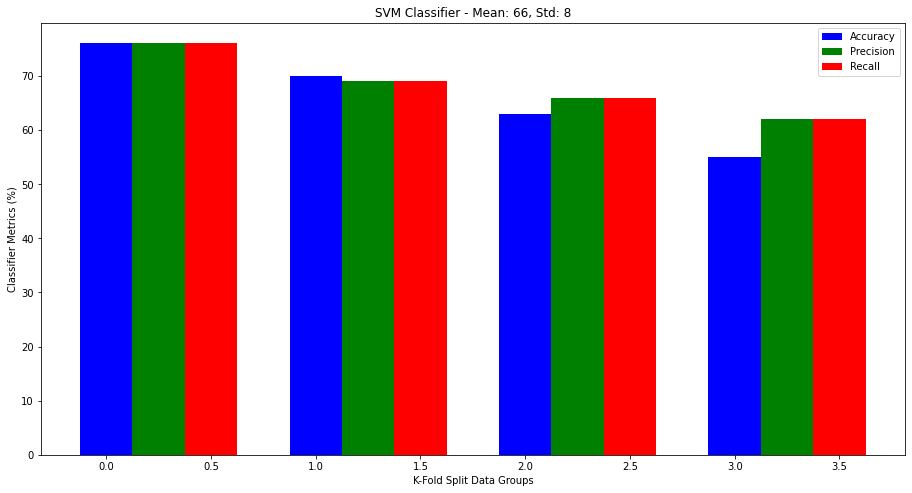

In [190]:
# Plot SVM results
# high precison = low false positive rate
# high recall = low false negative rate

fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0,0,1,1]) # add_axes(rect, projection=None, polar=False, **kwargs)
svm_data = [[76, 70, 63, 55], [76, 69, 66, 62], [76, 69, 66, 62]]
groups = ["1", "2", "3", "4"]
X = np.arange(4)
ax.bar(X + 0.00, svm_data[0], color = 'b', width = 0.25, label="Accuracy")
ax.bar(X + 0.25, svm_data[1], color = 'g', width = 0.25, label="Precision")
ax.bar(X + 0.50, svm_data[2], color = 'r', width = 0.25, label="Recall")
plt.title("SVM Classifier - Mean: 66, Std: 8")
plt.xlabel("K-Fold Split Data Groups")
plt.ylabel("Classifier Metrics (%)")
plt.legend()
plt.show()

## Similarity Measure

In [52]:
def calc_similarity(my_object, img1, img2):
    keypoints_a, descriptors_a = my_object.detectAndCompute(img1, None)
    keypoints_b, descriptors_b = my_object.detectAndCompute(img2, None)

    # brute force matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
    # bf = cv2.BFMatcher() # for SIFT
    matches = bf.match(descriptors_a, descriptors_b)

    # just for testing
    temp = []
    for i in matches:
        temp.append(i.distance)
    mean = np.mean(temp)
    max = np.max(temp)
    min = np.min(temp)
    # print("mean: ", mean)
    # print("max: ", max)
    # print("min: ", min)

    # calc similarity percentage
    similar_regions = [i for i in matches if i.distance < 75] #70
    # similar_regions = [i for i in matches if i.distance < 350] # for SIFT
    if (len(matches) == 0):
        return 0
    return(100*len(similar_regions) / len(matches))

In [53]:
orb = cv2.ORB_create()
orb_similarity = calc_similarity(orb, before[0], after[0])
print(orb_similarity)

# TODO make a plot of actual pairs vs random fake pairs

92.55319148936171


In [69]:
# create random (sort of) derrangement of after
after_indices = range(0, len(after))
after_rand = []

for i in range(len(after_indices)): 
    num = random.sample(after_indices, 2)
    if (num[0] != after_indices[i]):
        after_rand.append(num[0])
    else:
        after_rand.append(num[1])


In [70]:
print(after_rand[0])

46


In [73]:
# calc similarity array
similarities = []
fake_similarities = []
for i in range(len(before)):
    similarity = calc_similarity(orb, before[i], after[i])
    similarities.append(similarity)
    if similarity < 50:
        print(i)

    fake_sim = calc_similarity(orb, before[i], after[after_rand[i]])
    fake_similarities.append(fake_sim)


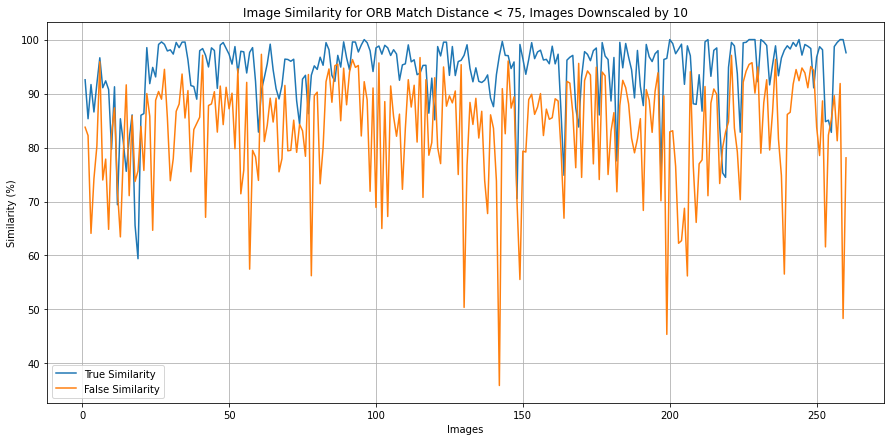

In [78]:
# graph similarity
x_axis = range(1, len(before) + 1)

plt.figure(figsize=(15, 7))

plt.plot(x_axis, similarities, label="True Similarity")
plt.plot(x_axis, fake_similarities, label="False Similarity")

plt.grid(True)
plt.legend()
plt.title("Image Similarity for ORB Match Distance < 75, Images Downscaled by 10")
plt.xlabel("Images")
plt.ylabel("Similarity (%)")
plt.show()